# Tutorial for XRR with GenX

In [1]:
import numpy as np
pi = np.pi
from pylab import genfromtxt
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline

## 0. Read me

Tutorial made for GenX 2.4.10.  
This tutorial is made in complement to the one available online http://genx.sourceforge.net/doc/tutorials/xrr_fitting.html   
GenX has also an in-built help available in the "About" menu.  

## 1. Define the sample

Go to the "Sample" menu. There are already two semi-infinite media: "Amb" for ambient and "Sub" for substrate. For those two layers the thickness d does not matter.  

GenX asks for 5 parameters per layer that we will describe individually.

### dens
The density of formula units, in units per $Å^3$ (i.e. scatterer per unit volume).
    $$dens = \frac{\rho[u/Å^3]}{u_{\rm scatt}}, $$ 
    with $\rho[u/Å^3]$ in atomic mass per $Å^3$ ($1u = 1.66054×10^{−27}$ kg),  
    and $u_{\rm scatt} = \sum_i u_i x_i$ the linear combination of the individual mass of each element.

A useful formula is then:
    $$dens = \frac{\rho[kg/m3]}{1.66054×10^3×u_{\rm scatt}}.$$
    

#### Case 1
If one has the chemical formula and the density $\rho$ in $g/cm^3$ one can directly use the formula above.  

Examples:  
- H2O, $\rho=$ 1 g/cm3 = 1000 kg/m^3.  
    $u_{\rm scatt} = 2*1.008 + 1*15.999 = 18.015 u$  
    $dens = 1000/(1.66054*10^3*18.015) = 0.03343$

    

In [2]:
rho_kgm3 = 1000
u_scatt = 2*1.008 + 1*15.999
dens = rho_kgm3/(1.66054*1e3*u_scatt)
print('dens = ', dens)

dens =  0.0334284617096744


- SrTiO3, $\rho=$ 5.12 g/cm3.  
    $u_{\rm scatt} = 1*87.62 + 1*47.87 +3*16 = 183.49 u$  
    $dens = 5.12*10^3/(1.66054*10^3*183.49) = 0.0168$

In [3]:
rho_kgm3 = 5.12*1e3
u_scatt = 1*87.62 + 1*47.87 + 3*16
dens = rho_kgm3/(1.66054*1e3*u_scatt)
print('dens = ', dens)

dens =  0.016803827658307787


#### Case 2
If one has the unit cell of a crystal structure, the genx density is simply:
$$ dens = n/a^3,$$  
with $n$ the number of molecules per unit cell and $a$ the cell size in $Å$.

Examples:  
- SrTiO3, cubic with a lattice constant a = 3.9045 $Å$.  
dens = 1/3.9045^3 = 0.0168

- Fe, bcc with a lattice constant a = 2.866 $Å$.  
dens = 2/2.866^3 = 0.085

#### Case 3
If one has the electron density $\rho_{el}$ in $e^-/Å^3$ and the number of electrons $n_{el}$:
$$ dens = \rho_{el}/n_{el}.$$  
Example:  
- a DSPC lipid head C10H18O8NP with a known $\rho_{el}=0.4$ $e^{-}/Å^3$:  
$dens = 0.4/(10*6+18*1+8*8+7+15)= 0.00244$

### sigmar
The root mean square roughness of the top interface of the layer in Å.

### sigmai
The root mean square interdiffusion of the top interface of the layer in Å.

### d
The thickness of the layer in Å.

### f
The x-ray scattering length per formula unit in electrons. GenX takes directly the scattering length of an element from CXRO when writing in f: fp.Si (Silicon for example). Linear combination of fp are possible, for example $\textrm{fp.Si + 2*fp.O}$ for SiO2.  
When writing the f manually, one has to write it as $\textrm{f1-f2*j}$ with f1 and f2 positive.

## 2. Define the instrument and the geometry

### wavelength
The wavelength in Å. You can use $\lambda=hc/E$ to convert energy to wavelength.  
With $E$ in eV and $\lambda$ in Å, $\lambda=12398/E$

In [4]:
E = 8000 #in eV
h = 4.135667662E-15 # in eV.s
c = 299792458E10  # in Å/s
wavelength = h*c/E
print('lambda in Å:', wavelength)


lambda in Å: 1.5498024673276163


### coords
The x-axis: $q$ in $1/Å$ or tth in degres (actually $2\theta$). In XRR one can go from one to the other with the formula:  
$$q = \frac{4\pi}{\lambda}\sin{\theta}.$$

### I0
The incident intensity (a scaling factor). Should be 1 if the normalization by the direct beam is good.

### Ibkg
The background intensity. Add a constant value to the calculated reflectivity. It can be estimated by an off-specular measurement.

### res 
The resolution of the instrument given in the same coordinates as the parameter coords. This assumes a gaussian relation function and res is the standard deviation of that gaussian. The resolution can be measured on a direct scan $I$ vs $2\theta$, or on a scan $I$ vs $\theta$ in reflection on a reflectivity plateau for ex. (but then the standard deviation measured should be multiplied by two).

['0:gamma', '1:delta', '2:ys', '3:ds1hg', '4:os2hg', '5:zs', '6:alphax', '7:gamma', '8:hu36energy', '9:xs', '10:thetah', '11:ds2hg', '12:ss1hg', '13:current', '14:mon2', '15:dioderefl', '16:mon4', '17:gainfemtodioderefl', '18:integration_time', '19:sensors_rel_timestamps', '20:sensorsTimestamps', '21:i15-c-cx1/ex/v2_grp_gamma.rot/rot']
fit results [ 1.58224902e+00  1.76335721e-04  1.17415941e-02 -2.28223011e-03]
res =  0.01


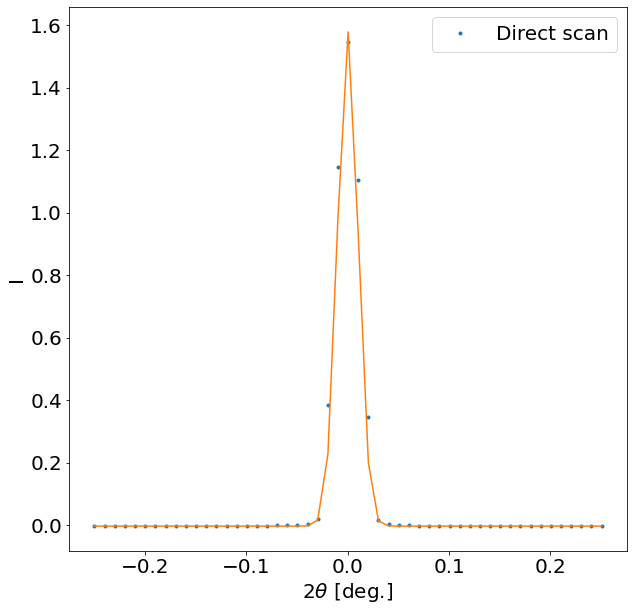

In [5]:
#Example with a direct scan

pathToFile = 'Example_Data/SIRIUS_2017_12_06_07308.dat'

#Get the list of column number + header name
header = genfromtxt(pathToFile, dtype = str)[0,:]
name_list = [str(i)+':'+header[i] for i in range(len(header))]
print(name_list)

def gaussian(x, amplitude, mean, stddev, bckg):
    return amplitude * np.exp(-(x - mean)**2 /(2*stddev**2)) + bckg

dat = genfromtxt(pathToFile,skip_header=1,usecols=(0,15))
x = dat[:,0]
y = dat[:,1]

p0 = (np.max(y), x[np.argmax(y)], 0.002, 0.) #Initial guess
popt, _ = optimize.curve_fit(gaussian, x, y, p0)
print('fit results', popt)

popt = popt

#To test other set of params
popt = [1.58224902e+00, 1.76335721e-04, 0.01, -2.28223011e-03]

print('res = ', popt[2])

plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 20})
plt.xlabel(r'$2\theta$ [deg.]')
plt.ylabel(r'I')
plt.plot(x, y, '.', label = 'Direct scan')
plt.plot(x, gaussian(x, *popt))
plt.legend()
plt.show()



#### restype 
Describes the type of resolution calculated. Alternatives: 'no conv', 'fast conv', 'full conv and varying res.' or 'fast conv + varying res.'. Note that fast convolution only allows a single value into res, whereas the others can also take an array with the same length as the x-data (varying resolution). 

#### respoints 
The number of points to include in the resolution calculation. This is only used for 'full conv and vaying res.' and 'fast conv + varying res'.

#### resintrange 
Number of standard deviations to integrate the resolution function.

#### footype 
Which type of footprint correction is to be applied to the simulation. One of: 'no corr', 'gauss beam' or 'square beam'.

#### beamw 
The width (vertical gap) of the beam given in mm. For 'gauss beam' it should be the standard deviation. For 'square beam' it is the full width of the beam. Can be measured on a height scan during the alignment.

['0:zs', '1:delta', '2:ys', '3:ds1hg', '4:os2hg', '5:zs', '6:alphax', '7:gamma', '8:hu36energy', '9:xs', '10:thetah', '11:ds2hg', '12:ss1hg', '13:current', '14:mon2', '15:dioderefl', '16:mon4', '17:gainfemtodioderefl', '18:integration_time', '19:sensors_rel_timestamps', '20:sensorsTimestamps', '21:i15-c-cx1/ex/v2_grp_zs.pos/pos']
(0.093318206786915, 67.1709374425, 0.15, 0.093318206786915)
fit results [ 0.09471659 66.78388415  0.12167327  0.09535   ]
beamw =  0.1216732716856213


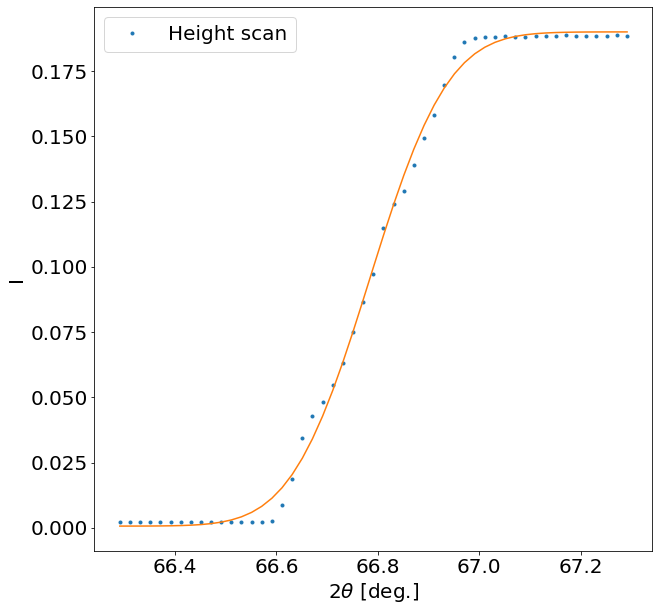

In [7]:
from scipy.special import erf

#Example with a height scan

pathToFile = 'Example_Data/SIRIUS_2017_12_06_07352.dat'

#Get the list of column number + header name
header = genfromtxt(pathToFile, dtype = str)[0,:]
name_list = [str(i)+':'+header[i] for i in range(len(header))]
print(name_list)

def cdf_gaussian(x, amplitude, x0, stddev, bckg):
    return amplitude*erf((x-x0)/(np.sqrt(2)*stddev))+bckg

dat = genfromtxt(pathToFile,skip_header=1,usecols=(0,15))
x = -dat[:,0]
y = dat[:,1]

hh = (np.max(y)-np.min(y))/2.
p0 = (hh, x[np.argmax(y-hh)], 0.15, hh) #Initial guess
print(p0)
popt, _ = optimize.curve_fit(cdf_gaussian, x, y, p0)
print('fit results', popt)

popt = popt

#To test other set of params
#popt = [0.1, 66.8, 0.15, 0.1]

print('beamw = ', popt[2])

plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 20})
plt.xlabel(r'$2\theta$ [deg.]')
plt.ylabel(r'I')
plt.plot(x, y, '.', label = 'Height scan')
plt.plot(x, cdf_gaussian(x, *popt))
plt.legend()
plt.show()

#### samplelen 
The length of the sample given in mm.

#### taylor_n 
The number of terms taken into account in the taylor expansion of the fourier integral of the correlation function. More terms means a more accurate calculation but also a much slower one. 